In [ ]:
!pip install mtcnn

In [2]:
!mkdir images

In [ ]:
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/andrew_ng1.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/andrew_ng2.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/deep_learning_heros.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/football_team.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/hinton1.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/hinton2.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/ian_goodfellow1.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/ian_goodfellow2.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/large_selfie.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/selfie.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/tqzdh.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/tqzdh2.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/yann_lecun1.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/yann_lecun2.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/yann_lecun3.jpg -P images
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/yann_lecun4.jpg -P images

# Import ArcFace Model Based on Resnet34

In [ ]:
!wget https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/ArcFace.py

In [5]:
import ArcFace
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np

In [6]:
model = ArcFace.loadModel()
face_detector = MTCNN()

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://drive.google.com/uc?id=1LVB3CdVejpmGHM28BpqqkbZP5hDEcdZY
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:01<00:00, 97.2MB/s]


In [7]:
def detect_face(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #mtcnn expects RGB but OpenCV read BGR
    detections = face_detector.detect_faces(img_rgb)
    face_list = []
    for detect in detections:
        x, y, w, h = detect["box"]
        cropped_face = img[int(y):int(y+h), int(x):int(x+w)]
        face_list.append(cropped_face)

    # Show face list
    plt.figure(figsize=(15, 15))
    face_count = len(detections)
    print(f"{face_count} faces have been detected")
    plot_row = int(face_count/3)+2    
    plt.subplot(plot_row, 3, 1)
    plt.imshow(img_rgb)
    i = 2
    for face in face_list:
        plt.subplot(plot_row, 3, i)
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        plt.imshow(face)
        i+=1
    plt.show()
    return face_list

In [8]:
def preprocess_face(img, target_size=(112,112)):
    img = cv2.imread(img)
    face_list = detect_face(img)
    face_list_pixels=[]
    for face in face_list:
        face = cv2.resize(face, target_size)
        face_pixels = image.img_to_array(face)
        face_pixels = np.expand_dims(face_pixels, axis = 0)
        face_pixels /= 255 #normalize input in [0, 1]
        face_list_pixels.append(face_pixels)

    return face_list_pixels

In [10]:
def img_to_encoding(path):
    face_list = preprocess_face(path)
    face_list_embedding = []
    for face in face_list:
        face_list_embedding.append(model.predict(face)[0])
    return face_list_embedding

1 faces have been detected


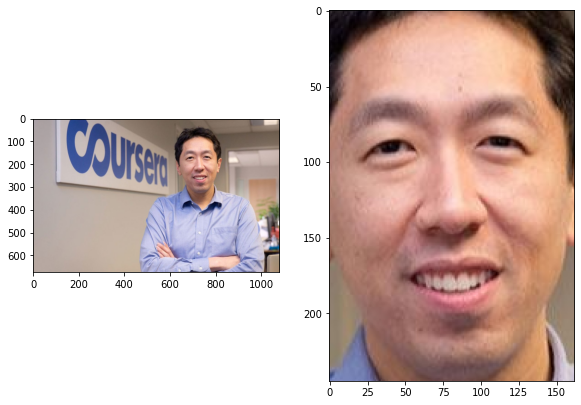

1 faces have been detected


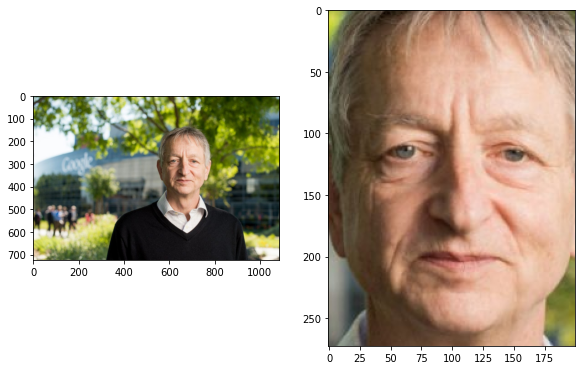

1 faces have been detected


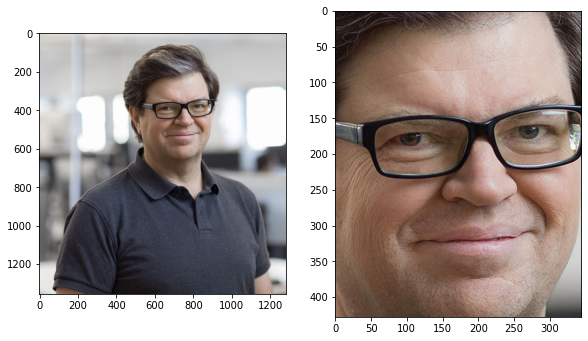

1 faces have been detected


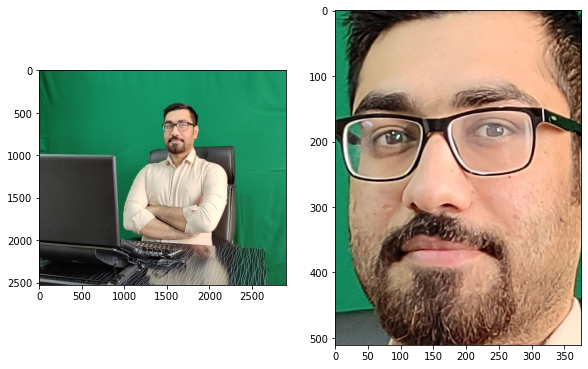

In [11]:
database = {}
database["andrew_ng"] = img_to_encoding("./images/andrew_ng2.jpg")[0]
database["hinton"] = img_to_encoding("./images/hinton2.jpg")[0]
database["yann_lecun"] = img_to_encoding("./images/yann_lecun4.jpg")[0]
database["mohammad_taghizadeh"] = img_to_encoding("./images/tqzdh2.jpg")[0]

In [12]:
def EuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [13]:
def CosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

##Threshold
We have distance values but how to determine a distance is low or high? The easiest way to determine it to feed lots of positive and negative instances. Then, decision tree algorithms can find the best split point. There are 37 positive; 239 negative; 276 total instances here.

![arcface-threshold](https://raw.githubusercontent.com/M-Taghizadeh/Deep-Face-Recognition/master/imgs/docs/arcface-threshold.jpg)

In [14]:
def findThreshold(metric):
   if metric == 'cosine':
      return 0.6871912959056619
   elif metric == 'euclidean':
      return 4.1591468986978075
   elif metric == 'euclidean_l2':
      return 1.1315718048269017

In [15]:
verification_threshhold = findThreshold("euclidean")

## Face Verification

In [16]:
def verify(image_path, identity, database):
    # Step 1: Compute the encoding for the image. Use img_to_encoding()
    encoding = img_to_encoding(image_path)[0] 
    
    # Step 2: Compute distance with identity's image
    dist = EuclideanDistance(encoding, database[identity])
    
    # Step 3: Open the door if dist < verification_threshhold, else don't open
    if dist < verification_threshhold:
        print("It's " + str(identity) + ", welcome!")
    else:
        print("It's not " + str(identity) + ", please go away")
             
    return dist

1 faces have been detected


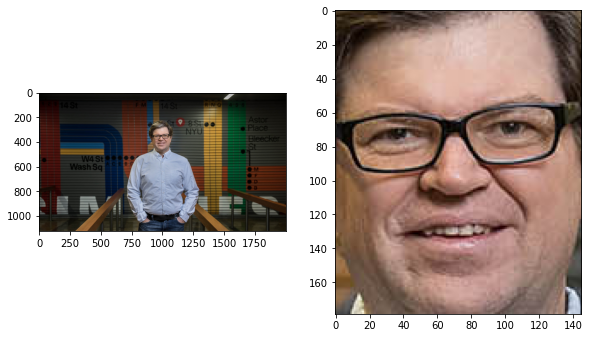

It's yann_lecun, welcome!


3.1711433

In [17]:
verify("images/yann_lecun2.jpg", "yann_lecun", database)

1 faces have been detected


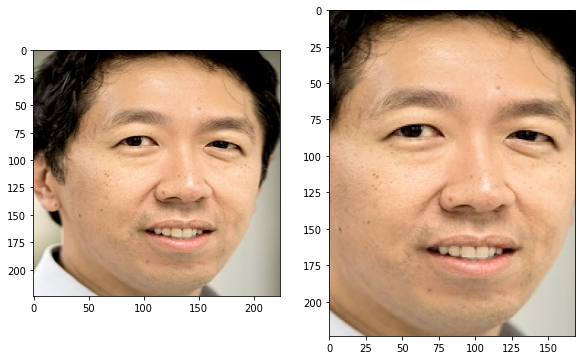

It's andrew_ng, welcome!


3.7144341

In [18]:
verify("images/andrew_ng1.jpg", "andrew_ng", database)

1 faces have been detected


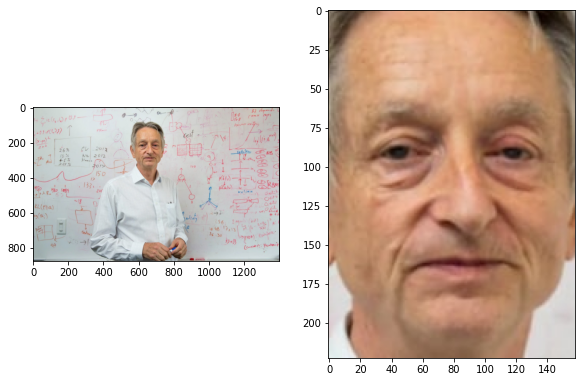

It's hinton, welcome!


3.3300693

In [19]:
verify("images/hinton1.jpg", "hinton", database)

1 faces have been detected


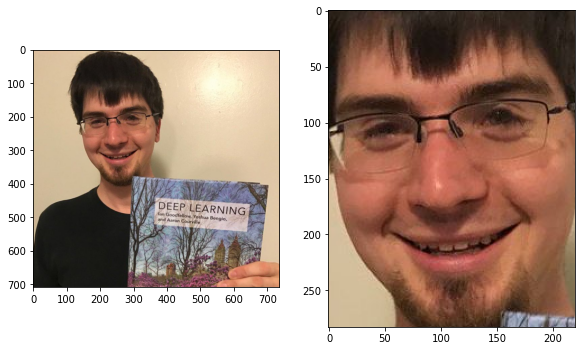

It's not yann_lecun, please go away


5.3683186

In [20]:
verify("images/ian_goodfellow2.jpg", "yann_lecun", database)

## Face Identification

In [21]:
def who_is_it(image_path, database):
   
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding()
    encodings = img_to_encoding(image_path)
    
    for encoding in encodings:
        ## Step 2: Find the closest encoding ##
        
        # Initialize "min_dist" to a large value, say 100 
        min_dist = 1000
        # Loop over the database dictionary's names and encodings.
        for (name, db_enc) in database.items():
            # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
            dist = EuclideanDistance(encoding, db_enc)

            # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
            if min_dist > dist:
                min_dist = dist
                identity = name

      
        if min_dist > verification_threshhold:
            print("Not in the database.")
        else:
            print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    # return min_dist, identity

4 faces have been detected


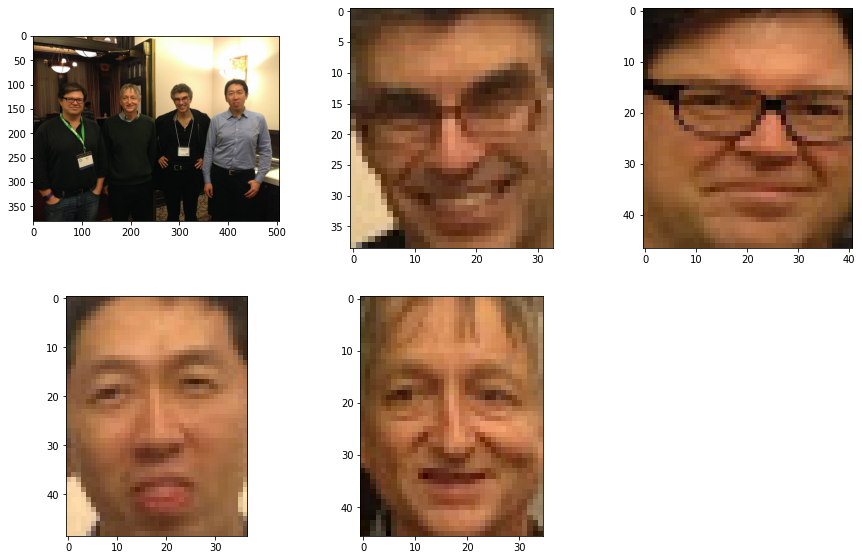

Not in the database.
it's yann_lecun, the distance is 2.6363528
it's andrew_ng, the distance is 3.4908237
it's hinton, the distance is 3.5374207


In [22]:
who_is_it("images/deep_learning_heros.jpg", database)

1 faces have been detected


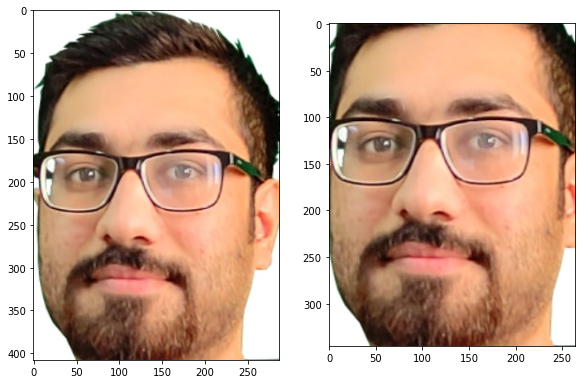

it's mohammad_taghizadeh, the distance is 2.7040155


In [23]:
who_is_it("images/tqzdh.jpg", database)